In [1]:
import pandas as pd

Titanic = pd.read_csv(r'Titanic.csv')
Titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# fix predictors
Titanic.drop(['PassengerId','Name','Ticket','Cabin'], axis = 1, inplace = True)
Titanic.isnull().sum(axis=0)

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [3]:
# fill age by sex groups
fillna_Titanic = []
for i in Titanic.Sex.unique(): #仅会计算不为NaN的均值
    update = Titanic.loc[Titanic.Sex == i].fillna(value={'Age':Titanic.Age[Titanic.Sex==i].mean()}, inplace=False)
    fillna_Titanic.append(update)
Titanic= pd.concat(fillna_Titanic)
Titanic.fillna(value = {'Embarked':Titanic.Embarked.mode()[0]}, inplace=True)
Titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.000000,1,0,7.2500,S
4,0,3,male,35.000000,0,0,8.0500,S
5,0,3,male,30.726645,0,0,8.4583,Q
6,0,1,male,54.000000,0,0,51.8625,S
7,0,3,male,2.000000,3,1,21.0750,S


In [4]:
# 转Category
Titanic.Pclass = Titanic.Pclass.astype('category')
#哑变量
dummy = pd.get_dummies(Titanic[['Sex','Embarked','Pclass']])
Titanic = pd.concat([Titanic, dummy], axis=1)
Titanic.drop(['Sex','Embarked','Pclass'], inplace=True, axis=1)
Titanic.head()

,Survived,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0,22.000000,1,0,7.2500,0,1,0,0,1,0,0,1
4,0,35.000000,0,0,8.0500,0,1,0,0,1,0,0,1
5,0,30.726645,0,0,8.4583,0,1,0,1,0,0,0,1
6,0,54.000000,0,0,51.8625,0,1,0,0,1,1,0,0
7,0,2.000000,3,1,21.0750,0,1,0,0,1,0,0,1


In [5]:
# 测试数据
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn import tree

predictors = Titanic.columns[1:]
X_train, X_test, y_train, y_test = model_selection.train_test_split(Titanic[predictors], Titanic.Survived, 
                                                                    test_size = 0.25, random_state = 1234)

#预设各参数
max_depth = [2,3,4,5,6]
min_samples_split = [2,4,6,8]
min_samples_leaf = [2,4,8,10,12]
parameters = {'max_depth':max_depth, 'min_samples_split':min_samples_split, 'min_samples_leaf':min_samples_leaf}
#网格搜索
grid_dtcateg = GridSearchCV(estimator = tree.DecisionTreeClassifier(), param_grid = parameters, cv=10)
grid_dtcateg.fit(X_train, y_train)
best_max_depth = grid_dtcateg.best_params_['max_depth']
best_min_samples_leaf = grid_dtcateg.best_params_['min_samples_leaf']
best_min_samples_split = grid_dtcateg.best_params_['min_samples_split']
best_max_depth, best_min_samples_leaf, best_min_samples_split

(6, 8, 4)

In [6]:
# 预测，评价
from sklearn import metrics
CART_Class = tree.DecisionTreeClassifier(max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf, min_samples_split=best_min_samples_split)
decision_tree = CART_Class.fit(X_train, y_train)
pred = decision_tree.predict(X_test)
print('模型在测试集的预测准确率：\n',metrics.accuracy_score(y_test, pred))

模型在测试集的预测准确率：
 0.8475336322869955


In [7]:
# ROC
import matplotlib.pyplot as plt
y_score = CART_Class.predict_proba(X_test)[:,1]
fpr,tpr,threshold = metrics.roc_curve(y_test, y_score)
# 计算AUC的值
roc_auc = metrics.auc(fpr,tpr)

# 绘制面积图
plt.stackplot(fpr, tpr, color='steelblue', alpha = 0.5, edgecolor = 'black')
# 添加边际线
plt.plot(fpr, tpr, color='black', lw = 1)
# 添加对角线
plt.plot([0,1],[0,1], color = 'red', linestyle = '--')
# 添加文本信息
plt.text(0.5,0.3,'ROC curve (area = %0.2f)' % roc_auc)
# 添加x轴与y轴标签
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
# 显示图形
plt.show()

<Figure size 640x480 with 1 Axes>

c:\program files\python37\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


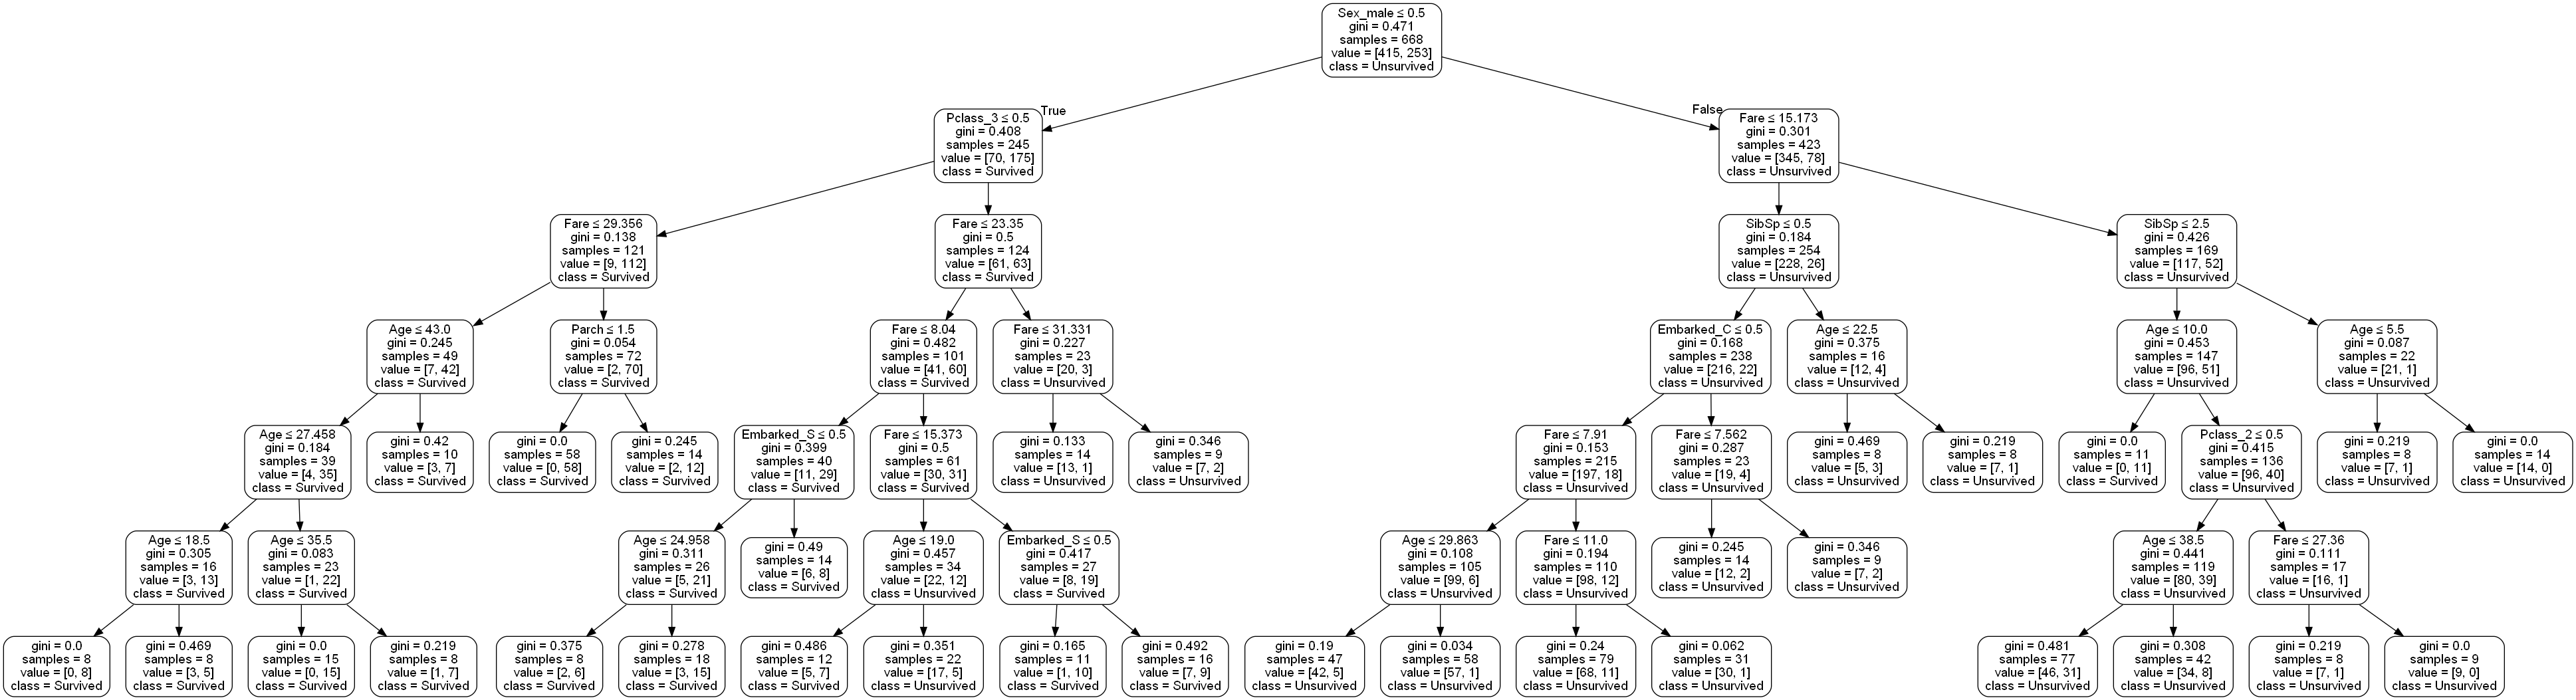

In [8]:
# 绘制决策树展示
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from sklearn.externals.six import StringIO

dot_data = StringIO()
export_graphviz(
    decision_tree,
    out_file=dot_data,  
    feature_names=predictors,
    class_names=['Unsurvived','Survived'],  
    # filled=True,
    rounded=True,  
    special_characters=True
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png()) 

In [9]:
# 随机森林
from sklearn import ensemble

RF_class = ensemble.RandomForestClassifier(n_estimators=200, random_state=1234)
RF_class.fit(X_train, y_train)
RFclass_pred = RF_class.predict(X_test)
print('模型在测试集的预测准确率：\n',metrics.accuracy_score(y_test, RFclass_pred))

模型在测试集的预测准确率：
 0.852017937219731


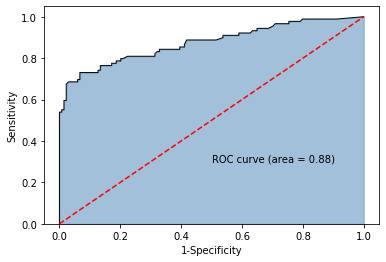

In [10]:
# ROC
y_score = RF_class.predict_proba(X_test)[:,1]
fpr,tpr,threshold = metrics.roc_curve(y_test, y_score)
roc_auc = metrics.auc(fpr,tpr)
# 绘图
plt.stackplot(fpr, tpr, color='steelblue', alpha = 0.5, edgecolor = 'black')
plt.plot(fpr, tpr, color='black', lw = 1)
plt.plot([0,1],[0,1], color = 'red', linestyle = '--')
plt.text(0.5,0.3,'ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.show()

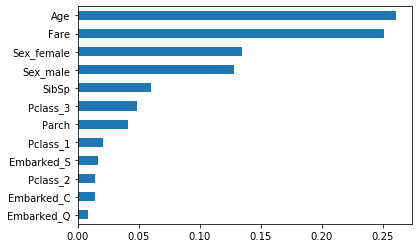

In [11]:
# 变量的重要程度值
importance = RF_class.feature_importances_
Impt_Series = pd.Series(importance, index = X_train.columns)
Impt_Series.sort_values(ascending = True).plot(kind='barh')
plt.show()

In [12]:
#回归决策树及随机森林

NHANES = pd.read_excel(r'NHANES.xlsx')
NHANES.head()
print(NHANES.shape)

(28009, 10)


In [13]:
# 取出自变量名称
predictors = NHANES.columns[:-1]
X_train, X_test, y_train, y_test = model_selection.train_test_split(NHANES[predictors], NHANES.CKD_epi_eGFR, 
                                                                    test_size = 0.25, random_state = 1234)

In [14]:
# 预设各参数的不同选项值
max_depth = [18,19,20,21,22]
min_samples_split = [2,4,6,8]
min_samples_leaf = [2,4,8]
parameters = {'max_depth':max_depth, 'min_samples_split':min_samples_split, 'min_samples_leaf':min_samples_leaf}
# 网格搜索法，测试不同的参数值
grid_dtreg = GridSearchCV(estimator = tree.DecisionTreeRegressor(), param_grid = parameters, cv=10)
# 模型拟合
grid_dtreg.fit(X_train, y_train)
# 返回最佳组合的参数值
grid_dtreg.best_params_

{'max_depth': 22, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [15]:
# 构建用于回归的决策树
CART_Reg = tree.DecisionTreeRegressor(max_depth = 22, min_samples_leaf = 2, min_samples_split = 2)
# 回归树拟合
CART_Reg.fit(X_train, y_train)
# 模型在测试集上的预测
pred = CART_Reg.predict(X_test)
# 计算衡量模型好坏的MSE值
metrics.mean_squared_error(y_test, pred)

1.8278527982625434

In [16]:
# 构建用于回归的随机森林
RF = ensemble.RandomForestRegressor(n_estimators=200, random_state=1234)
# 随机森林拟合
RF.fit(X_train, y_train)
# 模型在测试集上的预测
RF_pred = RF.predict(X_test)
# 计算模型的MSE值
metrics.mean_squared_error(y_test, RF_pred)

0.8943765841580971

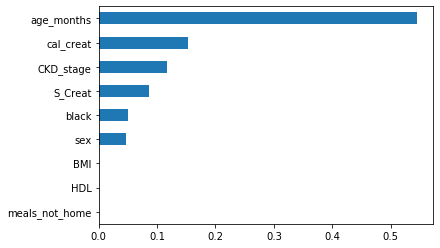

In [17]:
# 构建变量重要性的序列
importance = pd.Series(RF.feature_importances_, index = X_train.columns)
# 排序并绘图
importance.sort_values().plot(kind='barh')
plt.subplots_adjust(hspace=10)
plt.show()